In [1]:
import numpy as np
import pandas as pd
import json
import sys
import os
import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
import seaborn as sns
import pdb

from util import utils as data_utils

%pylab inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'Blues'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

json_file = './results/sparse_noise/entropy_reg_loss_correct_beta_reg_1/checkpoint_50.json'
FDIR = os.path.dirname(json_file)
NUM_CLASSIFY = 10

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Plot gradients norms for the entire learning process
grads_json_filename = os.path.join(FDIR, 'model_grads.json')
grads = [[], [], []]
grads_key = ['max_grad_w1_16', 'max_grad_w1_32', 'max_grad_w1_64']
if os.path.exists(grads_json_filename):
    with open(grads_json_filename, 'r') as fp:
        data = json.load(fp)
        for i, k in enumerate(grads_key):
            if data[0].get(k, None) is None:
                continue
            for batch_grads in data:
                grads[i].append(batch_grads[k])

def plot_grads(grads, title, x_label, y_label, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    # plt.subplot(2, 1, 1)
    plt.plot(grads)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    
for i, g in enumerate(grads):
    if len(g) > 0:
        plot_grads(g, grads_key[i], 'iterations', grads_key[i])
        # pass

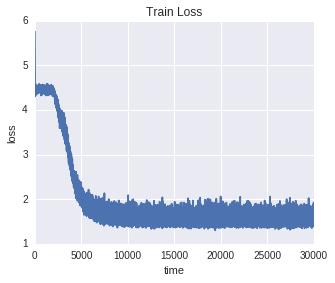

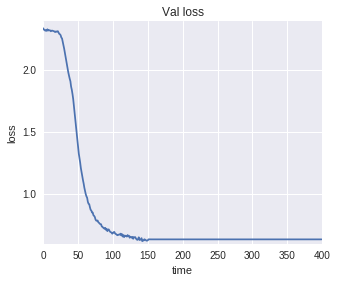

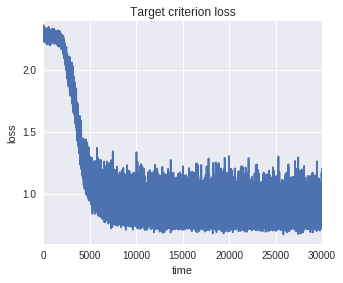

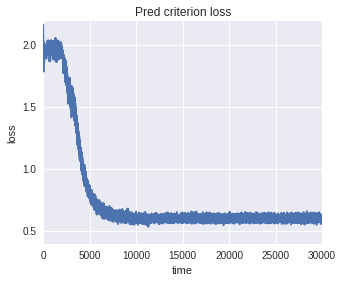

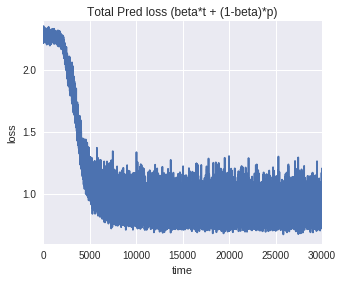

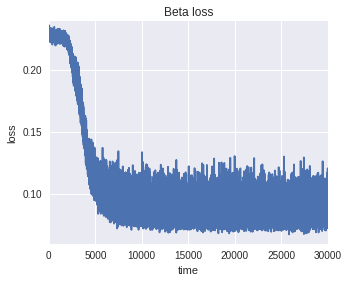

In [3]:
with open(json_file, 'r') as fp:
    data = json.load(fp)
# Loss history might not be of equal length.
train_loss_hist = data['train_loss_history']
val_loss_hist = data['val_loss_history']

# pdb.set_trace()
def plot_loss_hist(loss_hist, title,):
    plt.figure(figsize=(5,4))
    plt.subplot(1, 1, 1)
    plt.plot(loss_hist)
    plt.title(title)  # Train Loss
    plt.ylabel('loss')
    plt.xlabel('time')
    plt.show()
    
plot_loss_hist(train_loss_hist, 'Train Loss')
plot_loss_hist(val_loss_hist, 'Val loss')

if data.get('crit1_loss_history', None) is not None:
    plot_loss_hist(data['crit1_loss_history'], 'Target criterion loss')

if data.get('crit2_loss_history', None) is not None:
    plot_loss_hist(data['crit2_loss_history'], 'Pred criterion loss')

if data.get('pred_loss_history', None) is not None:
    plot_loss_hist(data['pred_loss_history'], 'Total Pred loss (beta*t + (1-beta)*p)')    

if data.get('beta_loss_history', None) is not None:
    plot_loss_hist(data['beta_loss_history'], 'Beta loss')

In [4]:
if data.get('KL_loss_history', None) is not None:
    # Loss history might not be of equal length.
    KL_loss_hist = data['KL_loss_history']

    plt.figure(figsize=(10,8))
    plt.plot(KL_loss_hist)
    plt.title('KL loss')
    plt.ylabel('loss')
    plt.xlabel('time')
    plt.show()

In [5]:
def get_conf(json_file, num_classes=26, json_key='conf'):
    with open(json_file, 'r') as fp:
        data = json.load(fp)
        conf = data.get(json_key, None)
    if conf is None:
        return
    # c1 = conf.split('\n')[1].split("]")[0].split("[ ")[1].split(" ")
    c1 = conf.split('\n')
    # print(c1)
    conf_mat, row_idx = np.zeros((num_classes, num_classes)), 0
    for i in c1:
        #pdb.set_trace()
        is_conf_row = False
        if ']' in i and '[[' in i:
            val = i.split(']')[0].split('[[')[1].split(' ')
            is_conf_row = True
        elif ']' in i and '[' in i:
            val = i.split(']')[0].split('[')[1].split(' ')
            is_conf_row = True
        if is_conf_row:
            col_idx = 0
            for v in val:
                if not len(v):
                    continue
                try:
                    conf_mat[row_idx, col_idx] = int(v)
                    col_idx = col_idx + 1
                except:
                    continue
            row_idx = row_idx + 1
    
    assert(row_idx == num_classes)
    conf_mat = conf_mat.astype(int)
    fdir = os.path.dirname(json_file)
    json_name = os.path.basename(json_file)[:-5]
    conf_file_name = fdir + '/' + 'conf_' + json_name + '.txt'
    np.savetxt(conf_file_name, conf_mat, fmt='%d', delimiter=', ')
    return conf_mat


def plot_conf(norm_conf):
  # Plot using seaborn
  # (this is style I used for ResNet matrix)
  plt.figure(figsize=(10,6))
  df_cm = pd.DataFrame(norm_conf)
  sns.heatmap(df_cm, annot=True, cmap="Blues")
  plt.show()

In [6]:
def get_sorted_checkpoints(fdir):
    # Checkpoint files are named as 'checkpoint_%d.json'
    checkpoint_map = {}
    for f in os.listdir(fdir):
        if f.endswith('json') and f.startswith('checkpoint'):
            checkpoint_num = int(f.split('checkpoint_')[-1].split('.')[0])
            checkpoint_map[checkpoint_num] = f
    sorted_checkpoints = []
    for k in sorted(checkpoint_map.keys()):
        v = checkpoint_map[k]
        sorted_checkpoints.append(v)
    return sorted_checkpoints

In [7]:
def best_f_scores(fdir, num_classes=5): 
    best_checkpoints = [None, None, None]
    best_3_fscores = [0, 0, 0]
    best_confs = [np.array(()), np.array(()), np.array(())]
    f1_weight_list = [1.0] * num_classes
    f1_weights = np.array(f1_weight_list)
    sorted_checkpoint_files = get_sorted_checkpoints(fdir)
    for f in sorted_checkpoint_files:
        json_file = fdir + '/' + f
        conf = get_conf(json_file, num_classes, json_key='val_conf')
        norm_conf = data_utils.normalize_conf(conf)
        f1 = data_utils.get_f1_score(conf, f1_weights)
        kappa = data_utils.computeKappa(conf)
        wt_f1 = data_utils.computeWeightedF1(conf)
        print('file: {}, f1: {:.3f}, kappa: {:.3f}, weighted-F1: {:.3f}'.format(
                f, f1, kappa, wt_f1))
        plot_conf(norm_conf)
        max_idx = -1
        for i in range(len(best_3_fscores)):
            if best_3_fscores[i] > f1:
                break
            max_idx = i
        for j in range(max_idx):
            best_3_fscores[j] = best_3_fscores[j+1]
            best_confs[j] = best_confs[j+1]
            best_checkpoints[j] = best_checkpoints[j+1]

        best_3_fscores[max_idx] = f1
        best_confs[max_idx] = conf
        best_checkpoints[max_idx] = f

    return best_3_fscores, best_confs, best_checkpoints

[[136069    913    734   1043    795   4058    950    833   1146  29559]
 [   447 185714   2329   2248   1815   4205    866 109164   1104  21358]
 [  1107   3476 131511   3828    904 109009    849   2387   3215  28664]
 [   649   3017   3232 145924   1199  10341    977   2655 100417  29789]
 [   915   1862    797   1909 130633   4225   1412   2869   1689 144189]
 [  1024   2921  96898   4205   1318 154241  70312   2083   3054  38144]
 [  1383   1307    913   1549    927  19221 160931    871   1103  21295]
 [   851 136567   2805   2339   1122   3422    810 148779   1356  22549]
 [   806   3173   2510 108721   1241  10866    767   2713 137188  30865]
 [ 97303   2324   1039   2120  99769   6237    964   4010   2423 201661]]
file: <built-in method f of mtrand.RandomState object at 0x7f8eaac695f0>, f1: 0.527, kappa: 0.248, weighted-F1: 0.510


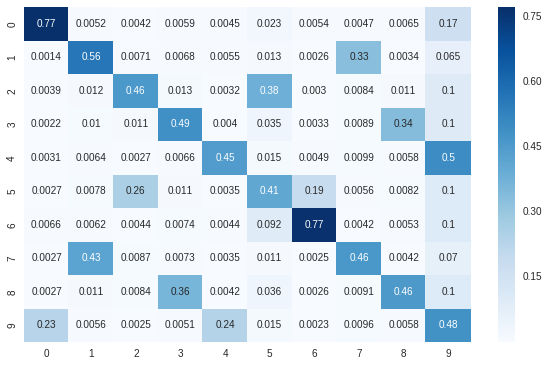

In [8]:
def plot_train_conf(fdir, num_classes=5):
    sorted_checkpoint_files = get_sorted_checkpoints(fdir)
    if len(sorted_checkpoint_files) > 0:
        last_checkpoint = sorted_checkpoint_files[-1]
        json_file = fdir + '/' + last_checkpoint
        conf = get_conf(json_file, num_classes=num_classes, json_key='train_conf')
        print(conf)
        norm_conf = data_utils.normalize_conf(conf)
        f1_weight_list = [1.0] * num_classes
        f1_weights = np.array(f1_weight_list)
        f1 = data_utils.get_f1_score(conf, f1_weights)
        kappa = data_utils.computeKappa(conf)
        wt_f1 = data_utils.computeWeightedF1(conf)
        print('file: {}, f1: {:.3f}, kappa: {:.3f}, weighted-F1: {:.3f}'.format(
            f, f1, kappa, wt_f1))
        plot_conf(norm_conf)

plot_train_conf(FDIR, num_classes=NUM_CLASSIFY)

file: checkpoint_1.json, f1: 0.018, kappa: 0.000, weighted-F1: 0.018


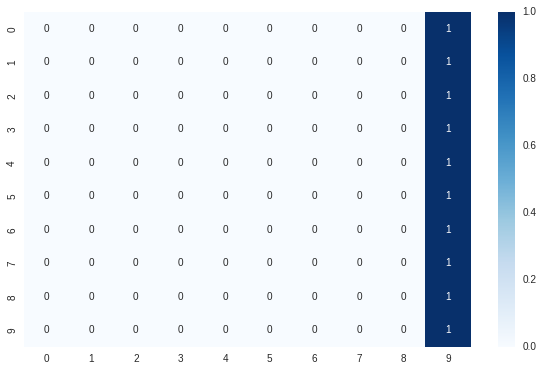

file: checkpoint_2.json, f1: 0.018, kappa: 0.000, weighted-F1: 0.018


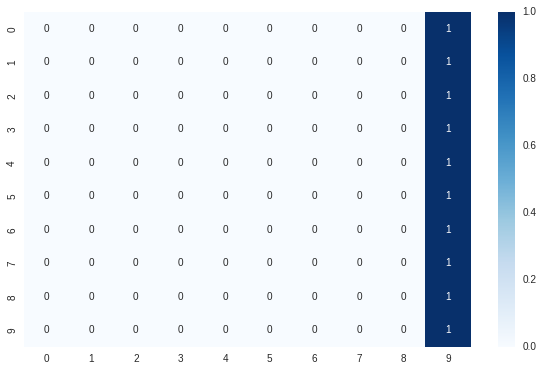

file: checkpoint_3.json, f1: 0.108, kappa: 0.183, weighted-F1: 0.120


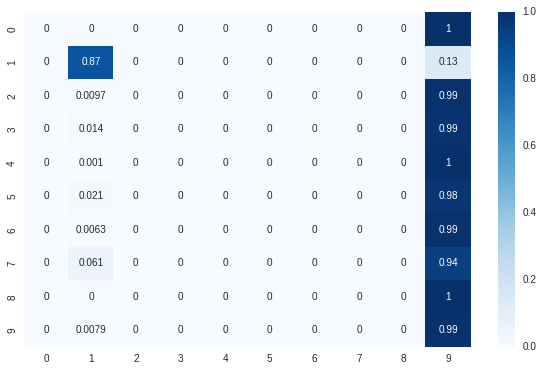

file: checkpoint_4.json, f1: 0.098, kappa: 0.128, weighted-F1: 0.106


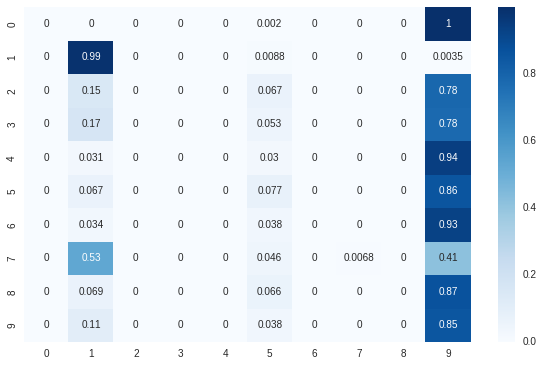

file: checkpoint_5.json, f1: 0.159, kappa: 0.183, weighted-F1: 0.169


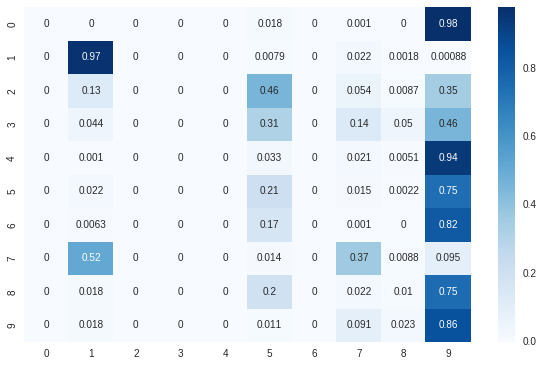

file: checkpoint_6.json, f1: 0.392, kappa: 0.450, weighted-F1: 0.403


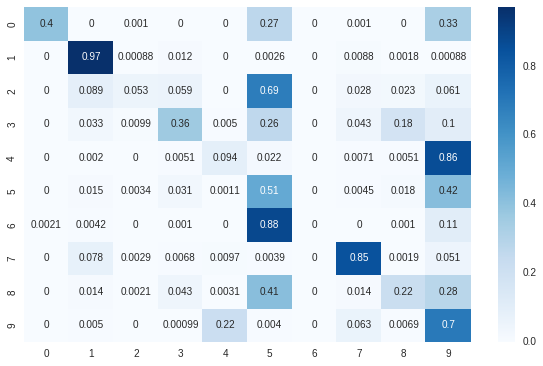

file: checkpoint_7.json, f1: 0.585, kappa: 0.550, weighted-F1: 0.591


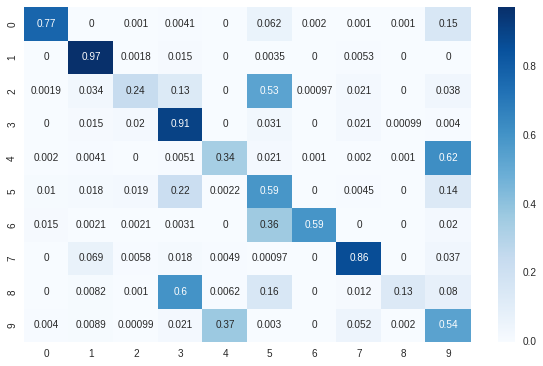

file: checkpoint_8.json, f1: 0.746, kappa: 0.656, weighted-F1: 0.750


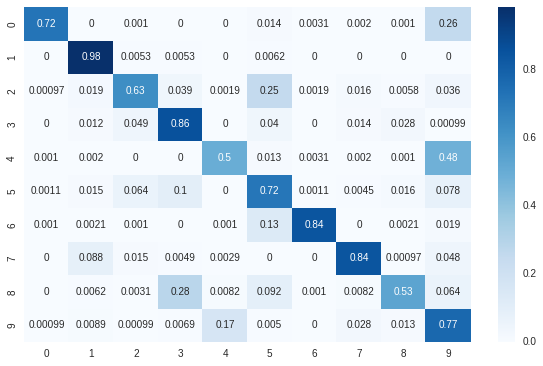

file: checkpoint_9.json, f1: 0.788, kappa: 0.699, weighted-F1: 0.790


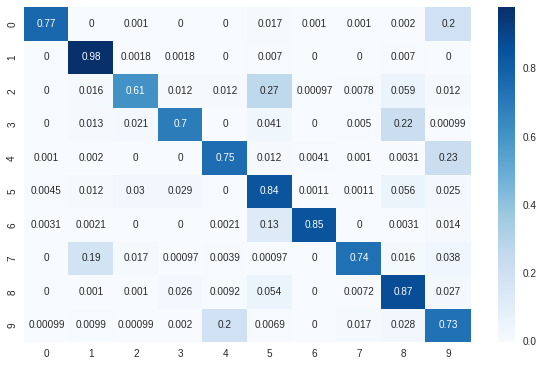

file: checkpoint_10.json, f1: 0.837, kappa: 0.795, weighted-F1: 0.839


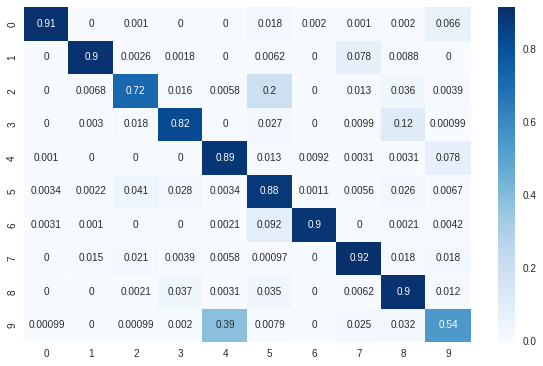

file: checkpoint_11.json, f1: 0.871, kappa: 0.818, weighted-F1: 0.873


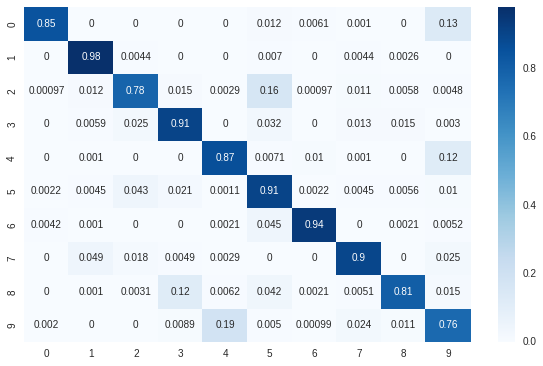

file: checkpoint_12.json, f1: 0.868, kappa: 0.799, weighted-F1: 0.870


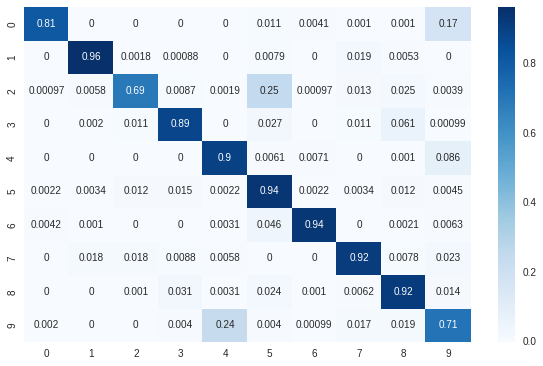

file: checkpoint_13.json, f1: 0.902, kappa: 0.872, weighted-F1: 0.903


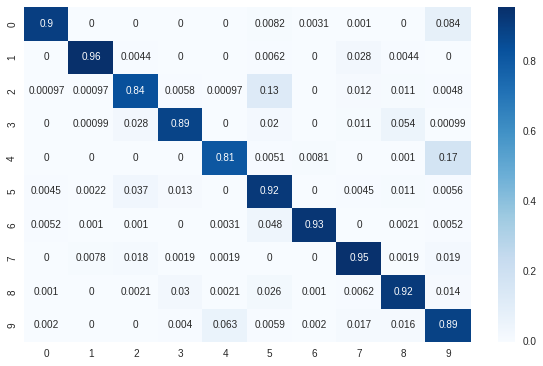

file: checkpoint_14.json, f1: 0.870, kappa: 0.802, weighted-F1: 0.871


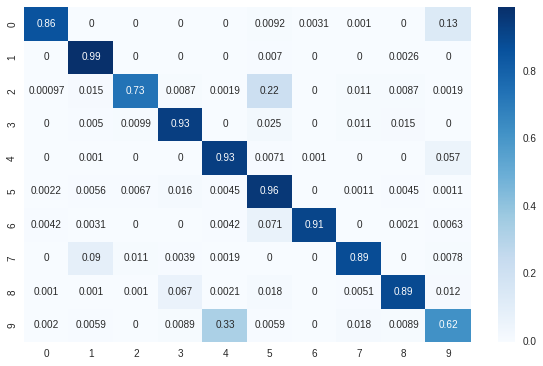

file: checkpoint_15.json, f1: 0.917, kappa: 0.898, weighted-F1: 0.919


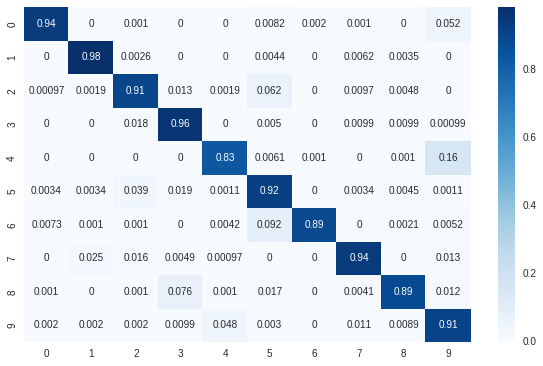

file: checkpoint_16.json, f1: 0.903, kappa: 0.822, weighted-F1: 0.904


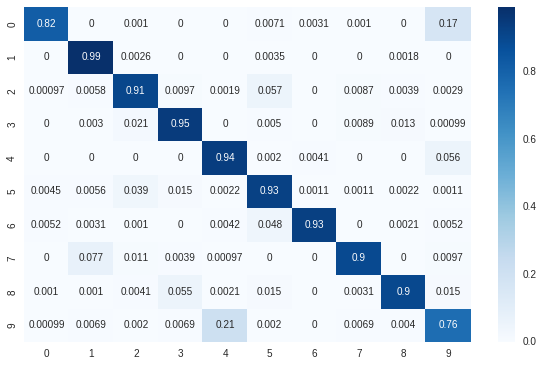

file: checkpoint_17.json, f1: 0.930, kappa: 0.906, weighted-F1: 0.931


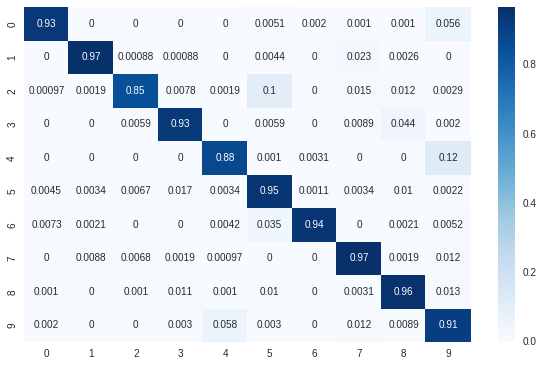

file: checkpoint_18.json, f1: 0.917, kappa: 0.885, weighted-F1: 0.917


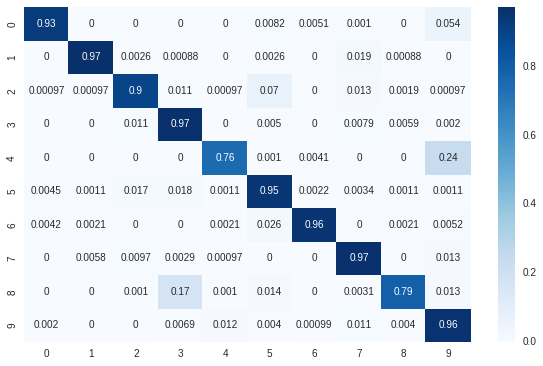

file: checkpoint_19.json, f1: 0.939, kappa: 0.920, weighted-F1: 0.940


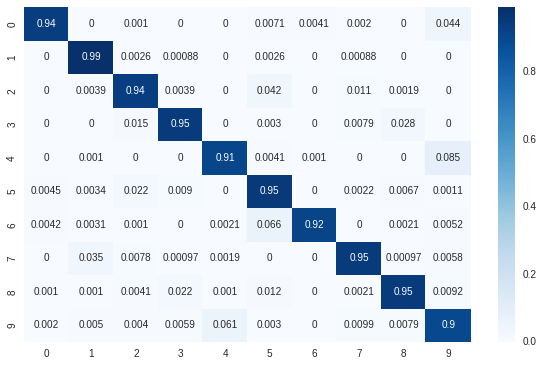

file: checkpoint_20.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


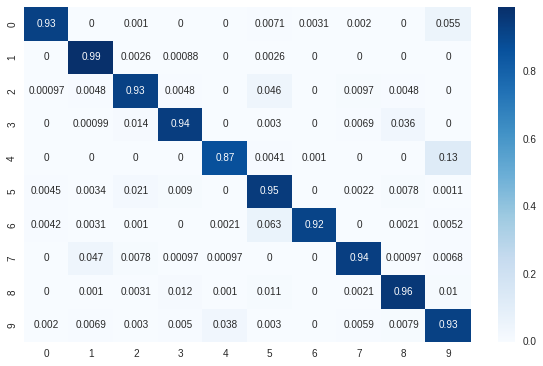

file: checkpoint_21.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


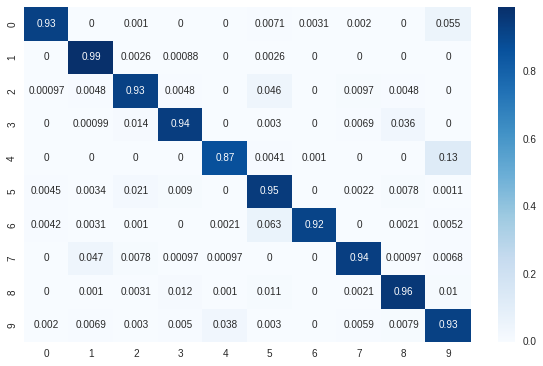

file: checkpoint_22.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


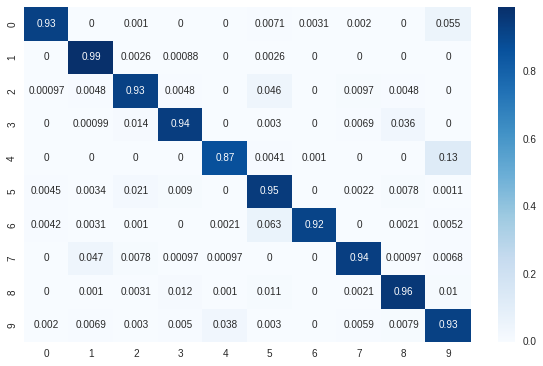

file: checkpoint_23.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


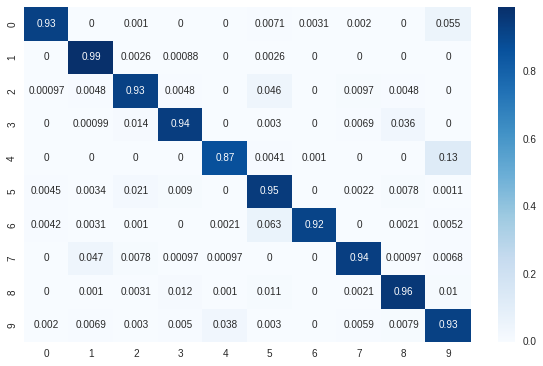

file: checkpoint_24.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


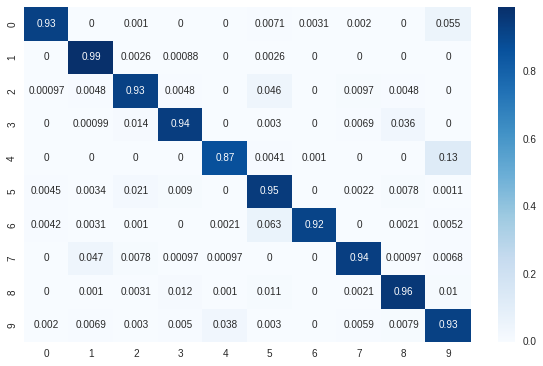

file: checkpoint_25.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


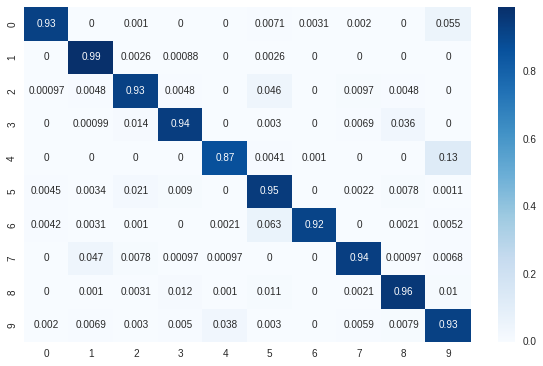

file: checkpoint_26.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


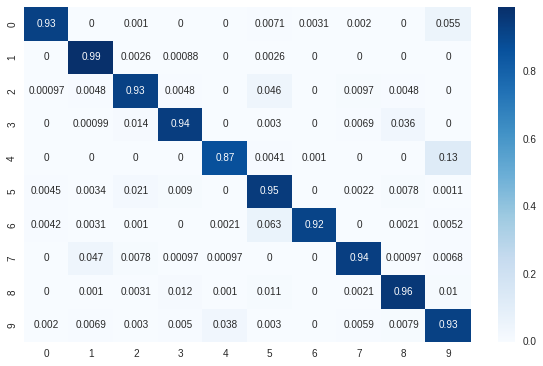

file: checkpoint_27.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


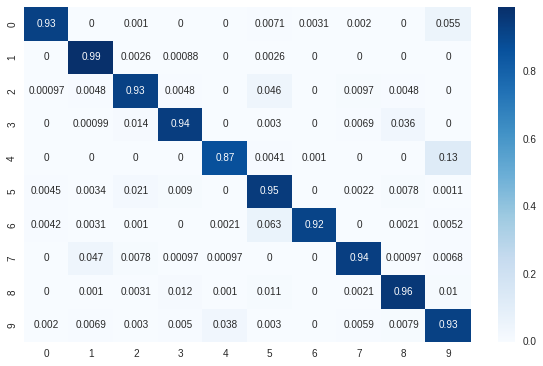

file: checkpoint_28.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


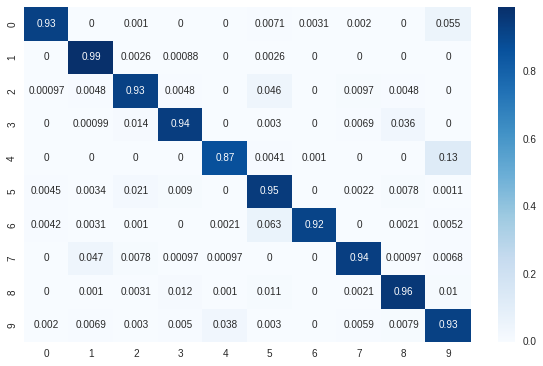

file: checkpoint_29.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


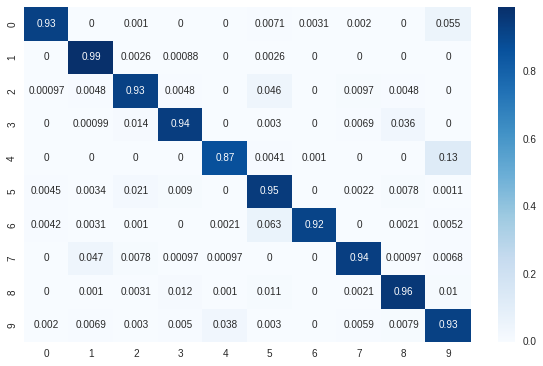

file: checkpoint_30.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


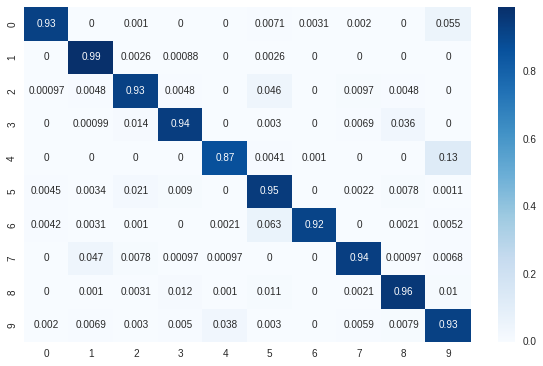

file: checkpoint_31.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


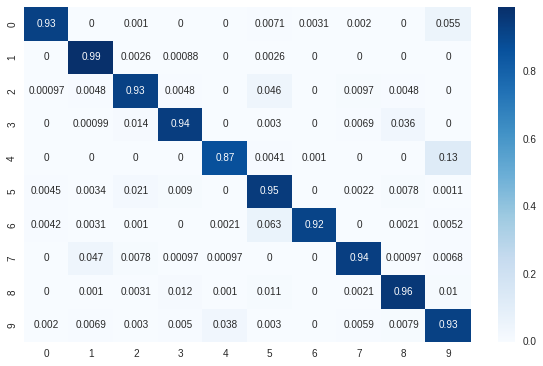

file: checkpoint_32.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


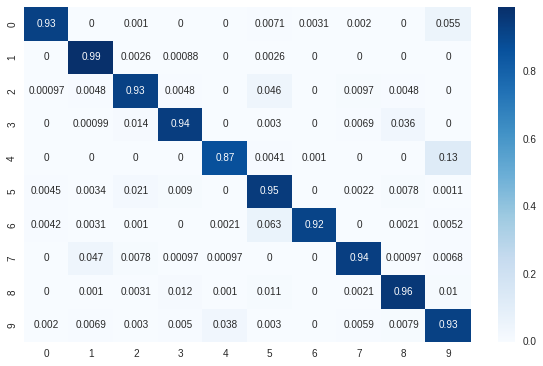

file: checkpoint_33.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


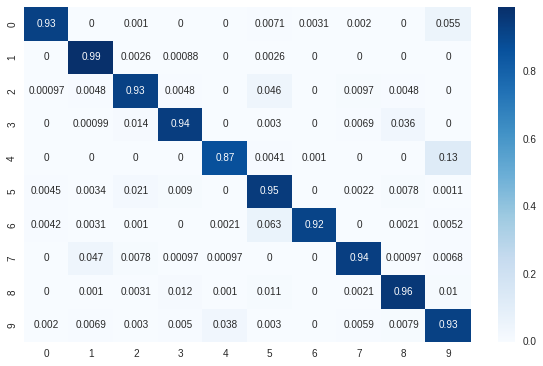

file: checkpoint_34.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


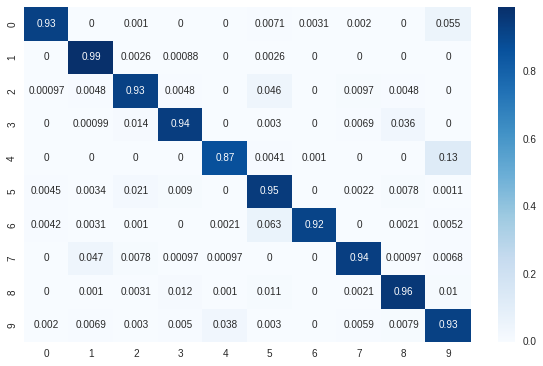

file: checkpoint_35.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


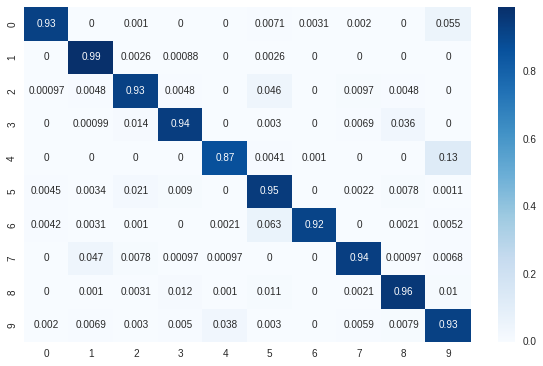

file: checkpoint_36.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


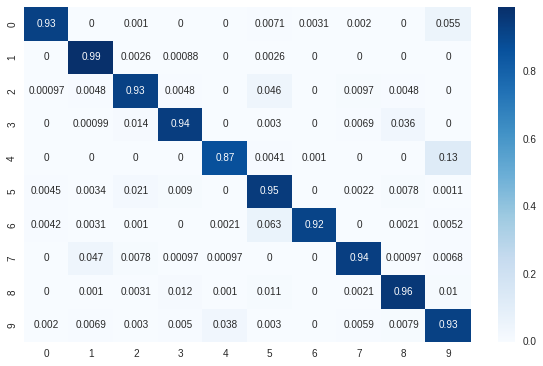

file: checkpoint_37.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


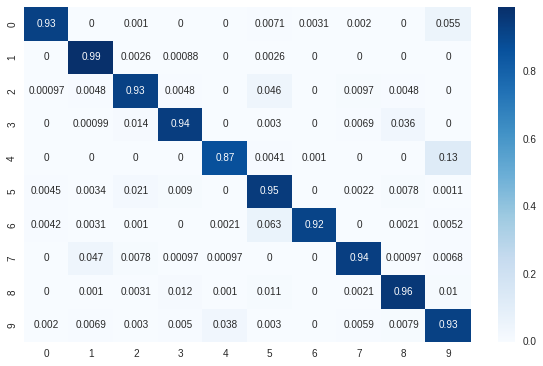

file: checkpoint_38.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


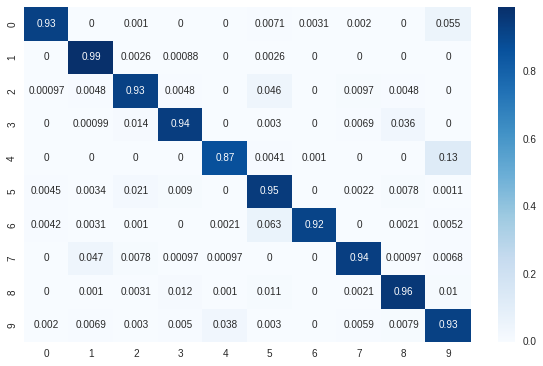

file: checkpoint_39.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


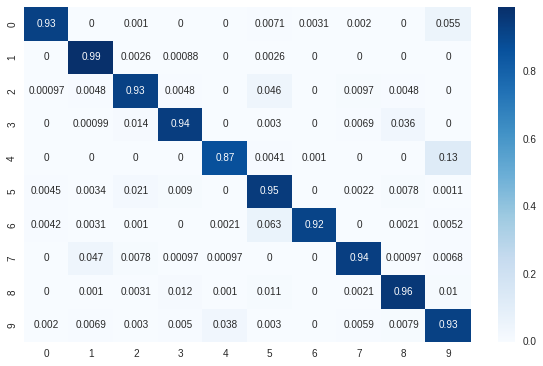

file: checkpoint_40.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


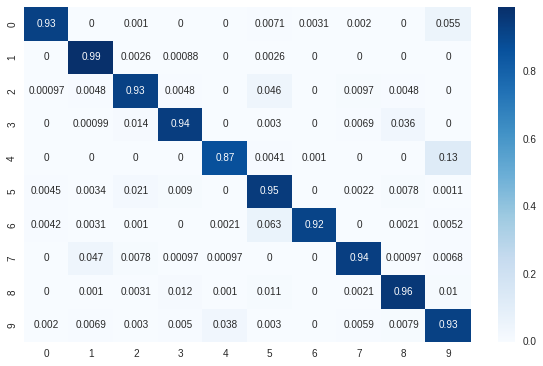

file: checkpoint_41.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


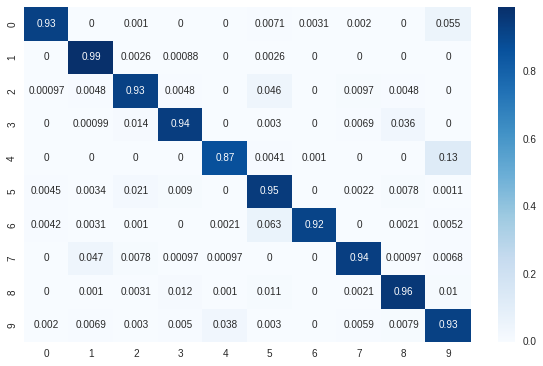

file: checkpoint_42.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


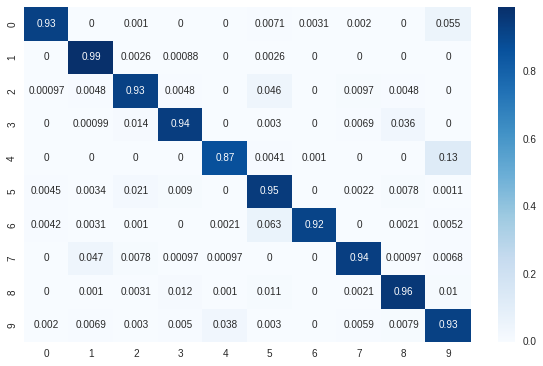

file: checkpoint_43.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


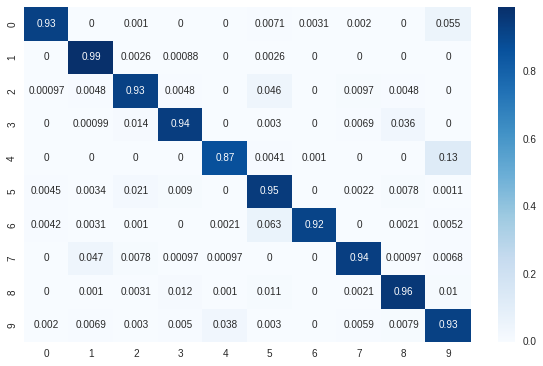

file: checkpoint_44.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


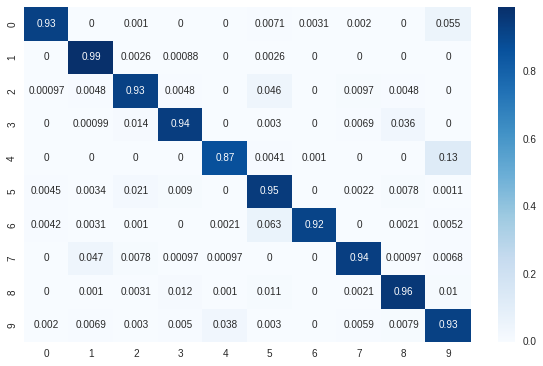

file: checkpoint_45.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


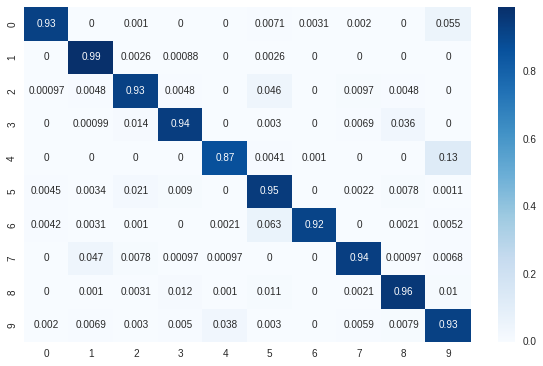

file: checkpoint_46.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


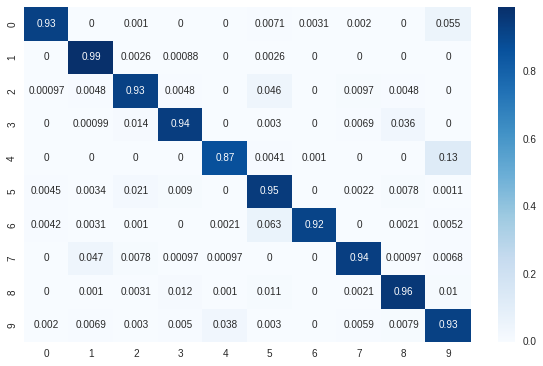

file: checkpoint_47.json, f1: 0.936, kappa: 0.911, weighted-F1: 0.937


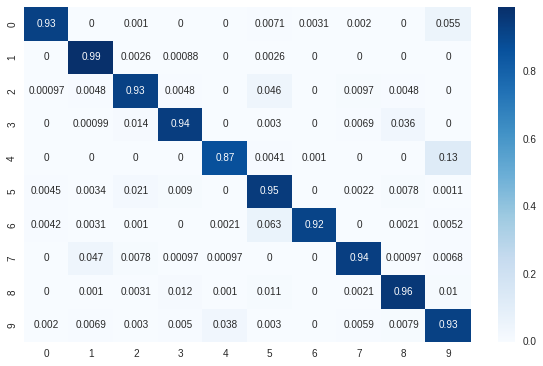

file: checkpoint_48.json, f1: 0.936, kappa: 0.910, weighted-F1: 0.936


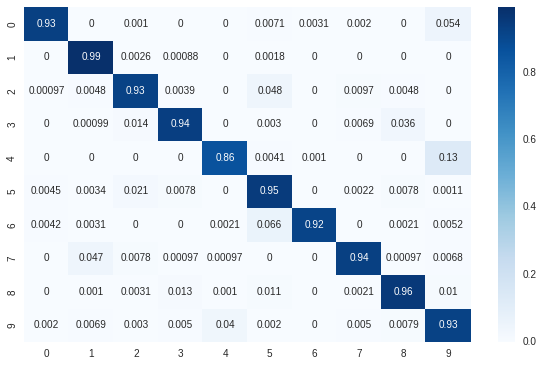

file: checkpoint_49.json, f1: 0.936, kappa: 0.910, weighted-F1: 0.936


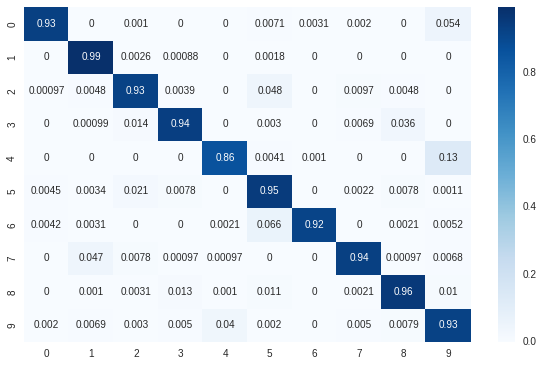

file: checkpoint_50.json, f1: 0.936, kappa: 0.910, weighted-F1: 0.936


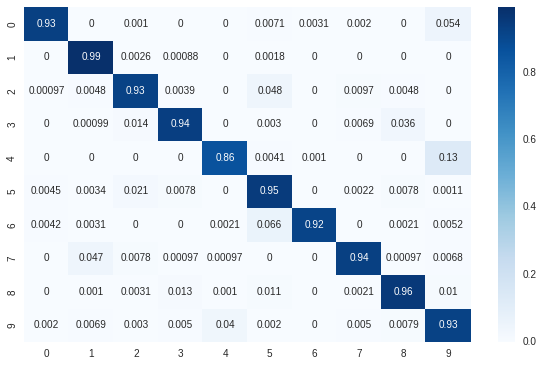

([0.93634494455291772, 0.93634494455291772, 0.93563025355403773],
 [array([[ 913,    0,    1,    0,    0,    7,    3,    2,    0,   54],
         [   0, 1128,    3,    1,    0,    3,    0,    0,    0,    0],
         [   1,    5,  959,    5,    0,   47,    0,   10,    5,    0],
         [   0,    1,   14,  949,    0,    3,    0,    7,   36,    0],
         [   0,    0,    0,    0,  854,    4,    1,    0,    0,  123],
         [   4,    3,   19,    8,    0,  848,    0,    2,    7,    1],
         [   4,    3,    1,    0,    2,   60,  881,    0,    2,    5],
         [   0,   48,    8,    1,    1,    0,    0,  962,    1,    7],
         [   0,    1,    3,   12,    1,   11,    0,    2,  934,   10],
         [   2,    7,    3,    5,   38,    3,    0,    6,    8,  937]]),
  array([[ 913,    0,    1,    0,    0,    7,    3,    2,    0,   54],
         [   0, 1128,    3,    1,    0,    3,    0,    0,    0,    0],
         [   1,    5,  959,    5,    0,   47,    0,   10,    5,    0],
         

In [9]:
best_f_scores(FDIR, num_classes=NUM_CLASSIFY)